# Interlab Study

This is our [Interlab study](http://2015.igem.org/Tracks/Measurement/Interlab_study). We studied three devices:

* Device 1 - J23101

* Device 2 - J23106

* Device 3 -  J23117

Fluorescence measurements were performed using an excitation at 485nm, followed by an end-point measure at 525nm.

In [1]:
%matplotlib inline

import sys
sys.path.insert(0, '../')
import BrasilUSP_iGEM_LabLib as LabLib

import scipy.stats
import pylab as pl
import numpy as np
import glob
from math import sqrt



## Definitions...

def biolrepl(wells):
    return np.array( [ wells[0:3].mean(), wells[3:6].mean(), wells[6:9].mean() ] ), \
        np.array( [ np.std(wells[0:3]), np.std(wells[3:6]), np.std(wells[6:9]) ] )

ColumnNames = {
    'A' : "LB",
    'B' : "LB+Cam",
    'C' : "Dev1",
    'D' : "Dev2",
    'E' : "Dev3",
    'F' : "+control",
    'G' : "-control1",
    'H' : "-control2",
}

MeaningColNames = { v: k for k, v in ColumnNames.items()}

def allCols(labels, r0 = 1, rf = 9):
    if type(labels) != list: 
        labels = [labels]
    cols = []
    for label in labels:
        row  = MeaningColNames[label]
        for j in range(r0,rf+1):
            cols.append(row + '0' + str(j))
    return cols

### Reading measurements

Reading the file with the measurements. In these files we have two fluorescence measurements:

* GFP: excited 485nm, probed 525nm
* RFP: excited 584nm, probed 607nm

In [2]:
FLlist = []
ODlist = []
tidx   = []
for file in glob.glob("medida*.txt"):
    tidx.append( float( file.split(' ')[1].split('.')[0] ) )
    FLlist.append(file)
    ODlist.append('OD'+file.split(' ')[1].split('.')[0]+'.txt')

Idx = np.argsort(tidx)
FLlist = np.array(FLlist)[Idx]
ODlist = np.array(ODlist)[Idx]

# Do we have the list of files sorted properly?
print FLlist

['medida 1.txt' 'medida 2.txt' 'medida 3.txt' 'medida 4.txt' 'medida 5.txt'
 'medida 6.txt' 'medida 7.txt' 'medida 8.txt' 'medida 9.txt'
 'medida 10.txt' 'medida 11.txt' 'medida 12.txt' 'medida 13.txt']


Reading all the data...

In [3]:
fldata = LabLib.ReadFluor_timefmt_nanomed(FLlist)
#oddata = LabLib.ReadFluor_timefmt_nanomed(ODlist, nr_header=2)

Let's take a look at the LB row...

In [4]:
fldata[allCols('LB')].head(3)

,A01,A02,A03,A04,A05,A06,A07,A08,A09
0,896.879,924.144,899.629,796.180,936.492,826.367,759.291,792.928,946.623
1,946.583,938.596,928.959,790.242,946.989,838.949,777.353,790.383,963.707
2,694.778,774.716,718.264,533.280,735.652,606.997,629.488,703.695,852.307


Name for each row.

Let's quickly check how the temperature varied during the experiment.

Average temperature: 24.6'C
Temperature range: 23.0'C - 26.2'C


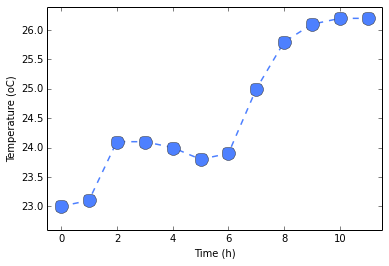

In [5]:
print "Average temperature: %4.1f'C" % (fldata['T(oC)'].mean())
print "Temperature range: %4.1f'C - %4.1f'C" % (fldata['T(oC)'].min(), fldata['T(oC)'].max())

pl.plot(fldata['T(oC)'], 'o--', lw=1.5, markersize=13., color=(0.3,0.5,1.0), markeredgecolor=(0.2,0.2,0.2))
pl.xlabel('Time (h)')
pl.xlim(-0.5,11.5)
pl.ylabel('Temperature (oC)')
pl.ylim(22.6,26.4)
pl.show()

### Control

Part of the control was contamined. To compute the average we have simply removed those points (all colony 3 and last column of colony 2).

Red curve = LB+Cam
Black curve = LB


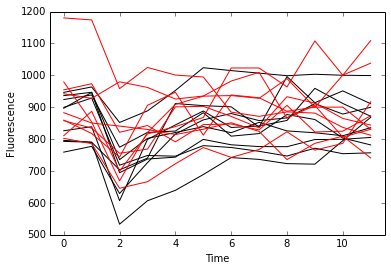

In [6]:
print 'Red curve = LB+Cam'
print 'Black curve = LB'

pl.plot(fldata[allCols('LB')], color='k')
pl.plot(fldata[allCols('LB+Cam')], color='r')

pl.xlabel('Time')
pl.xlim(-0.5,11.5)
pl.ylabel('Fluorescence')
pl.show()

In [7]:
LB_mean    = fldata[allCols('LB')].mean().mean()
LBCam_mean = fldata[allCols('LB+Cam')].mean().mean()

print "Mean with LB: \t\t %5.1f " % (LB_mean)
print "Mean with LB+Cam: \t %5.1f " % (LBCam_mean)
print "\nDifference: \t\t %5.1f"  % (np.abs(LB_mean - LBCam_mean))

Mean with LB: 		 830.6 
Mean with LB+Cam: 	 877.6 

Difference: 		  47.0


Let's test if there are statistically significant differences between colonies with and without antibiotics. The two-sample [Mann-Whitney U test](https://en.wikipedia.org/wiki/Mann%E2%80%93Whitney_U_test) checks two samples whether one of them is consistently smaller than the other.

In [8]:
fldata[allCols('LB')].shape

(12, 9)

In [9]:
# Putting all data in a single row...
LB    = np.reshape( np.array( fldata[allCols('LB')] ), (12*9) )
LBCam = np.reshape( np.array( fldata[allCols('LB+Cam')] ), (12*9) )

scipy.stats.mannwhitneyu(LB, LBCam)

(4300.0, 0.00042698997509228736)

According to the above p-value (~$0.4$%), the antibiotic is inducing a bit o fluorescence.

### Normalizing the fluorescence measurements

Since all colonies have antibiotics, we will normalize all fluorescence with respect to LB+Cam. Thus, from now on all values are given in units of LBCam_mean.

In [10]:
NormDevs = fldata[allCols( ['Dev1', 'Dev2', 'Dev3'] )]/LBCam_mean
NormDevs[['C01', 'D01', 'E01']].head(5)

,C01,D01,E01
0,2.085633,1.371107,1.181830
1,2.168587,1.525179,1.251136
2,2.208550,1.516833,0.982312
3,2.792530,1.943513,1.168060
4,3.441266,2.229200,1.088706


Plotting fluorescence for each population


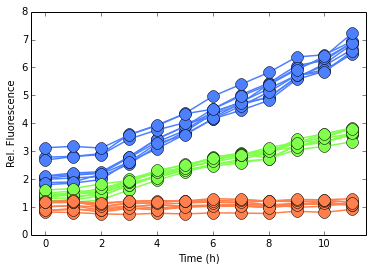

In [11]:
print 'Plotting fluorescence for each population'

colors = {'1':(0.3,0.5,1.0), '2':(0.5,1.0,0.3), '3':(1.0,0.5,0.3)}
for dev in ['1','2','3']:
    pl.plot(NormDevs[allCols('Dev'+dev)], 'o-', lw=1.5, markersize=12., color=colors[dev])

pl.xlabel('Time (h)')
pl.xlim(-0.5, 11.5)
pl.ylabel('Rel. Fluorescence')
pl.show()

Plotting averages over all replicates


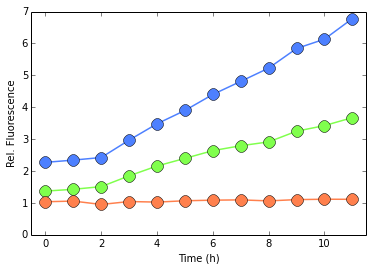

In [12]:
print 'Plotting averages over all replicates'

for dev in ['1','2','3']:
    pl.plot(np.mean(np.array(NormDevs[allCols('Dev'+dev)]), axis=1), 
            'o-', lw=1.5, markersize=12., color=colors[dev])

pl.xlabel('Time (h)')
pl.xlim(-0.5, 11.5)
pl.ylabel('Rel. Fluorescence')
pl.show()


In Devs we have the now normalized measurements for all three devices. Let's start by checking if the differences are statistically significant

In [13]:
Dev1all = np.reshape( np.array( NormDevs[allCols('Dev1')] ), (12*9) )
Dev2all = np.reshape( np.array( NormDevs[allCols('Dev2')] ), (12*9) )
Dev3all = np.reshape( np.array( NormDevs[allCols('Dev3')] ), (12*9) )

U, p12 = scipy.stats.mannwhitneyu(Dev1all,Dev2all)
U, p23 = scipy.stats.mannwhitneyu(Dev2all,Dev3all)
U, p13 = scipy.stats.mannwhitneyu(Dev1all,Dev3all)

print '1 vs 2: ', p12
print '2 vs 3: ', p23
print '1 vs 3: ', p13

1 vs 2:  5.96053278077e-17
2 vs 3:  5.37185636276e-36
1 vs 3:  3.05351690116e-37


All p-values are basically zero. Since they are all below $2.5$%, their differences are statistically significant.

### Plotting normalized results

Let's visualize now the data.

In [14]:
colors = [(0.3, 0.5, 1.0), (0.2, 1.0, 0.2), (1.0,0.2,0.2)]
x = [0.8, 1.0, 1.2, 1.8, 2.0, 2.2, 2.8, 3.0, 3.2]
colonies = np.array( [1.0, 2.0, 3.0] )

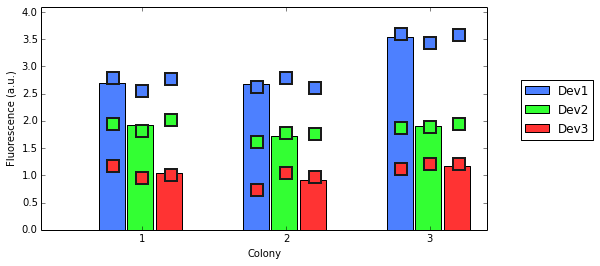

In [15]:
pl.figure( figsize=(8,4) )

time = 3
maxF = 2.
RowNames = ['Dev1', 'Dev2', 'Dev3']

for linen in [1,2,3]:
    X = NormDevs[allCols('Dev'+str(linen))].iloc[time]
    maxF = max(X.max(), maxF)
    pl.plot(x, X, 's', markersize=12., markeredgewidth=2.,
            markerfacecolor=colors[linen-1], markeredgecolor=(0.1,0.1,0.1))
    vals, stds = biolrepl( X )
    pl.bar(colonies + linen*0.2 - 0.5, vals, 0.18, color=colors[linen-1], label = RowNames[linen-1])
    
pl.xlabel('Colony')
pl.ylabel('Fluorescence (a.u.)')
pl.xlim(0.3,3.4)
pl.xticks([1.0, 2.0, 3.0])
pl.ylim(0, maxF + 0.5)
pl.legend(bbox_to_anchor=(1.25, 0.7))
pl.show()

In the graph above, we have two different measurements: Square points are each value of each technical replicates, and bars represent average within the same colony. This is not the **best** visualization in fact, see below for a better graph.

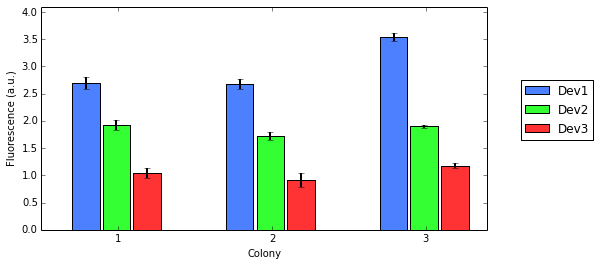

In [16]:
pl.figure( figsize=(8,4) )

error_config = {'ecolor': '0.', 'width': 10.0, 'linewidth' : 2.}
time = 3
maxF = 2.

for linen in [1,2,3]:
    X = NormDevs[allCols('Dev'+str(linen))].iloc[time]
    maxF = max(X.max(), maxF)
    vals, stds = biolrepl( X )
    pl.bar(colonies + linen*0.2 - 0.5, vals, 0.18, color=colors[linen-1], label = RowNames[linen-1],
           yerr=stds, error_kw=error_config)

pl.xlabel('Colony')
pl.ylabel('Fluorescence (a.u.)')
pl.xlim(0.5,3.4)
pl.xticks([1.0, 2.0, 3.0])
pl.ylim(0,maxF+0.5)
pl.legend(bbox_to_anchor=(1.25, 0.7))
pl.show()

### Relative fluorescence

All promoters are part of the known [Anderson's collection](http://parts.igem.org/Promoters/Catalog/Anderson), and all promoters have their *relative promoter strenghts* measured. A simple measure to have an initial insight on how each device operate relative to the others is to calculate the ratio between each average fluorescence measure.

Plotting averages over all replicates


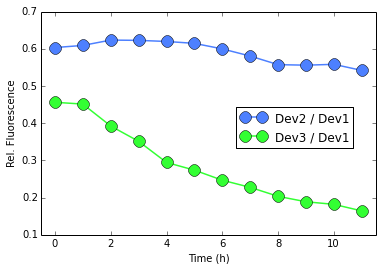

In [17]:
print 'Plotting averages over all replicates'

pl.plot(
    np.mean(np.array(NormDevs[allCols('Dev2')]), axis=1)/np.mean(np.array(NormDevs[allCols('Dev1')]), axis=1), 
    'o-', lw=1.5, markersize=12., color=colors[0], label='Dev2 / Dev1')
pl.plot(
    np.mean(np.array(NormDevs[allCols('Dev3')]), axis=1)/np.mean(np.array(NormDevs[allCols('Dev1')]), axis=1),
    'o-', lw=1.5, markersize=12., color=colors[1], label='Dev3 / Dev1')

pl.xlabel('Time (h)')
pl.xlim(-0.5, 11.5)
pl.ylabel('Rel. Fluorescence')
pl.legend(bbox_to_anchor=(0.95,0.6))
pl.show()

### Proper measure of promoter strength

We can also use the original definition of the relative promoter strength to make a more appropriate comparison [Kelly et al 2009].

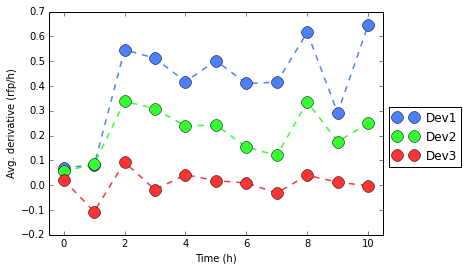

In [42]:
derivative = {}
for dev in [1,2,3]:
    derivative['Dev'+str(dev)] = np.mean( np.diff( np.array(NormDevs[allCols('Dev'+str(dev))]), axis=0), axis=1)
    pl.plot( derivative['Dev'+str(dev)], 
            'o--', lw=1.5, markersize=12., color=colors[dev-1], label='Dev'+str(dev) )

pl.legend(bbox_to_anchor=(1.25,0.6))
pl.xlabel('Time (h)')
pl.xlim(-0.5,10.5)
pl.ylabel('Avg. derivative (rfp/h)')
pl.show()

Finally, measuring the **R.P.U.**...

In [38]:
edF_1 = derivative['Dev1'].mean()
edF_2 = derivative['Dev2'].mean()
edF_3 = derivative['Dev3'].mean()

print 'RPU(J23106) = ', edF_2/edF_1
print 'RPU(J23117) = ', edF_3/edF_1

RPU(J23106) =  0.510941194255
RPU(J23117) =  0.0170352707068
